In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import re
import pandas as pd
import numpy as np
from scipy.special import gamma as GammaFunction
import pymc as pm
import arviz as az
import bambi as bmb
import pytensor.tensor as at
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
import attila_utils
#plt.rcParams['figure.dpi'] = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
group2condition = {
    'A': 'WT',
    'B': '5xFAD',
    'C': '5xFAD + Amiloride',
}

## Training trials

In [3]:
fpath = '../../resources/QPS/5xFAD-mouse/amiloride-behavioral-data-cleaned.xlsx'
mwm = pd.read_excel(fpath, sheet_name='rawdata MWM day 1-4', header=[0,1], index_col=None)
mwm = pd.DataFrame(mwm.iloc[:, 4:].to_numpy(), columns=mwm.iloc[:, 4:].columns, index=pd.MultiIndex.from_frame(mwm.iloc[:, :4].xs('Covariates', axis=1, level=0)))
mwm = mwm.stack(level=1)
mwm = mwm.rename_axis(mwm.index.names[:-1] + ['Day'], axis=0)
mwm = pd.concat([mwm, mwm.index.to_frame()], axis=1)
mwm['Day'] = mwm.Day.str.replace('Day ', '').astype('float64')
#mwm['Day'] = mwm.Day.str.replace('Day ', '').astype(pd.Int64Dtype())
mwm['Condition'] = mwm.Group.apply(lambda x: group2condition[x])
mwm['Status'] = np.where(mwm['Latency (s)'] < 60, 'none', 'right') # censoring status
mwm = mwm.rename({'Latency (s)': 'Latency'}, axis=1)
mwm

Distance (m)  Floating %  Latency  \
Cohort Group Sex IRN     Day                                        
I      A     f   12913 A Day 1     10.841028    0.532622    60.08   
                         Day 2      5.720320    7.641773    26.06   
                         Day 3      3.967948    9.397345    22.70   
                         Day 4      2.178462    6.630220    18.06   
                 12915 A Day 1      8.892240    4.043839    47.62   
...                                      ...         ...      ...   
III    C     m   13958 A Day 4      3.717858    7.993118    20.74   
                 13962 A Day 1     10.552825    1.930759    60.08   
                         Day 2      9.089775    0.798936    60.08   
                         Day 3      3.030865    7.857635    19.78   
                         Day 4      6.122248    4.698587    33.14   

                                Thigmotaxis %  Velocity (m/s) Cohort Group  \
Cohort Group Sex IRN     Day                                                 
I      A     f   12913 A Day 1      66.311600        0.180684      I     A   
                         Day 2      33.259165        0.202247      I     A   
                         Day 3      16.170368        0.166473      I     A   
                         Day 4       7.830300        0.120461      I     A   
                 12915 A Day 1      70.582225        0.182376      I     A   
...                                       ...             ...    ...   ...   
III    C     m   13958 A Day 4      32.184900        0.165693    III     C   
                 13962 A Day 1      44.906775        0.175880    III     C   
                         Day 2      18.708375        0.151496    III     C   
                         Day 3      15.243320        0.154832    III     C   
                         Day 4      25.740050        0.176833    III     C   

                               Sex      IRN  Day          Condition Status  
Cohort Group Sex IRN     Day                                                
I      A     f   12913 A Day 1   f  12913 A  1.0                 WT  right  
                         Day 2   f  12913 A  2.0                 WT   none  
                         Day 3   f  12913 A  3.0                 WT   none  
                         Day 4   f  12913 A  4.0                 WT   none  
                 12915 A Day 1   f  12915 A  1.0                 WT   none  
...                             ..      ...  ...                ...    ...  
III    C     m   13958 A Day 4   m  13958 A  4.0  5xFAD + Amiloride   none  
                 13962 A Day 1   m  13962 A  1.0  5xFAD + Amiloride  right  
                         Day 2   m  13962 A  2.0  5xFAD + Amiloride  right  
                         Day 3   m  13962 A  3.0  5xFAD + Amiloride   none  
                         Day 4   m  13962 A  4.0  5xFAD + Amiloride   none  

[172 rows x 12 columns]

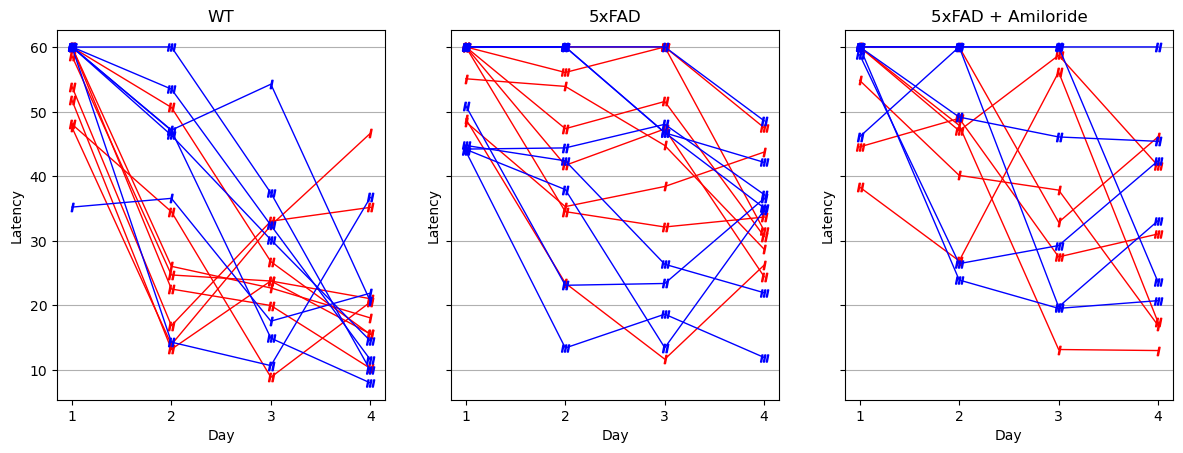

In [4]:
def data_plotter(yname='Latency', mwm=mwm):
    fig, ax = plt.subplots(1, len(mwm.Group.unique()), sharey=True, figsize=(3 * 4.8, 4.8))
    for group, axi in zip(mwm.Group.unique(), ax):
        axi.set_title(group2condition[group])
        axi.set_ylabel(yname)
        axi.set_xlabel('Day')
        axi.set_xticks(range(5))
        axi.set_xticklabels(range(5))
        axi.grid(axis='y')
        df1 = mwm.xs(group, level=1)
        for sex, color in zip(df1.Sex.unique(), ['red', 'blue']):
            df2 = df1.xs(sex, level=1)
            for irn, _ in zip(df2.IRN.unique(), plt.color_sequences['tab20'][:len(df2.IRN.unique())]):
                df3 = df2.xs(irn, level=1)
                for cohort in df3.Cohort.unique():
                    s = sex + cohort
                    y = df3[yname]
                    x = df3.Day
                    axi.plot(x, y, color=color, label=irn, marker='$' + cohort + '$', linewidth=1)
                pass
            pass
        #axi.legend()
    return((fig, ax))

fig, ax = data_plotter(yname='Latency')

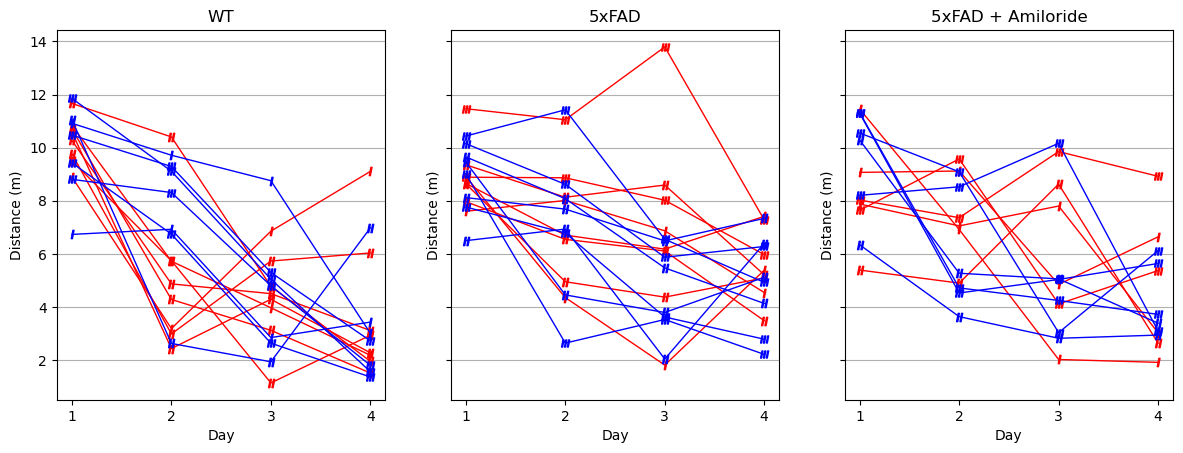

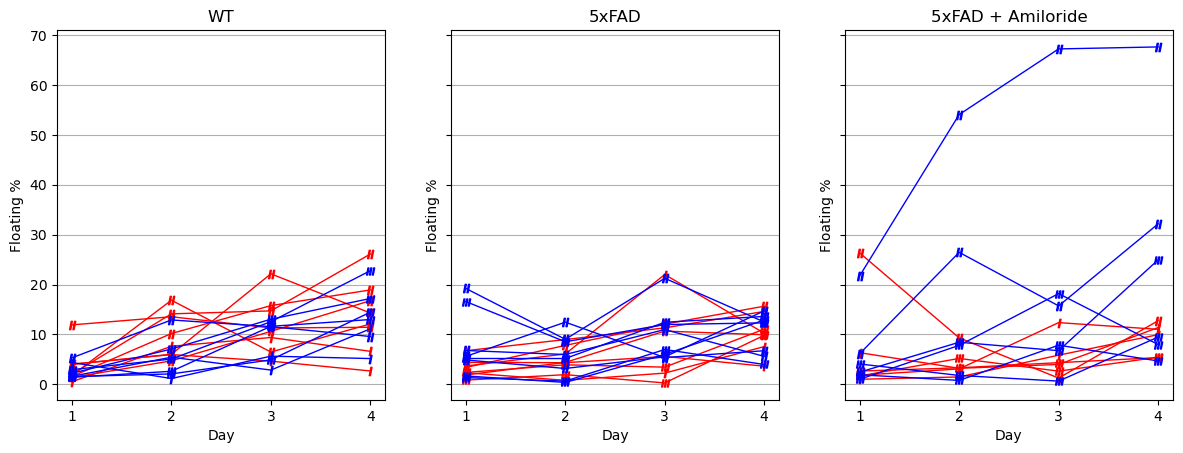

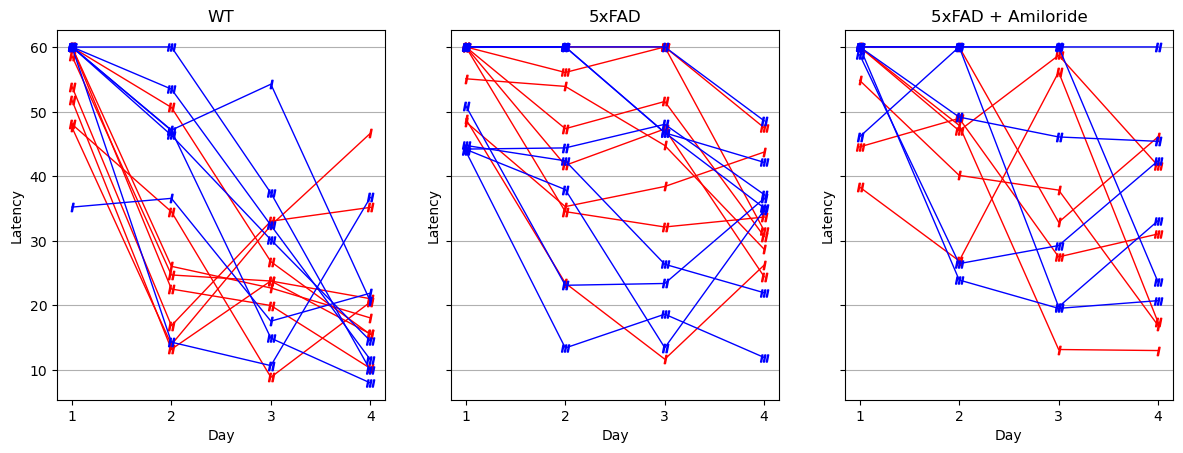

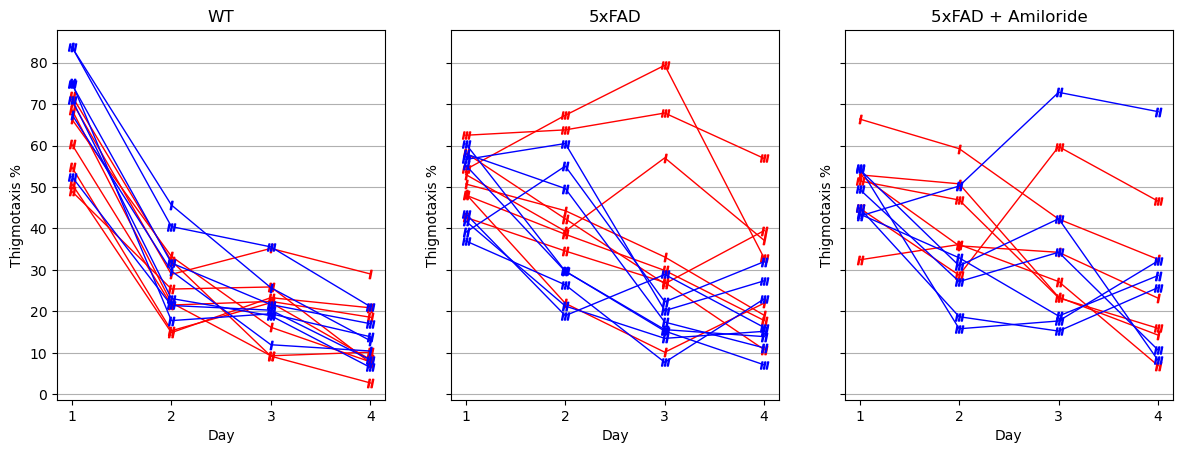

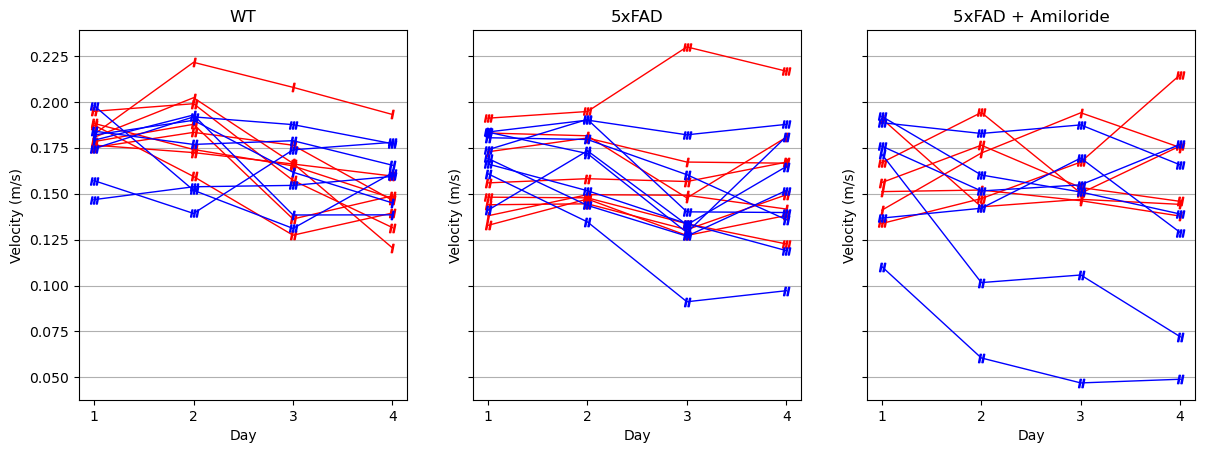

In [5]:
for yname in mwm.loc[:, :'Velocity (m/s)'].columns:
    fig, ax = data_plotter(yname=yname)
    attila_utils.savefig(fig, 'training-' + re.sub('[ ()%/]+', '-', yname).strip('-'))

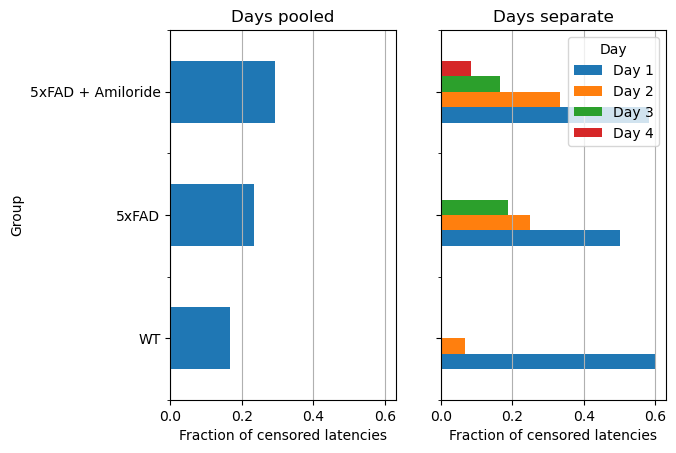

In [6]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
for title, axi, by in zip(['Days pooled', 'Days separate'], ax, ['Group', ['Group', 'Day']]):
    s = (mwm['Latency'] >= 60).groupby(by).mean()
    d = s.unstack() if axi == ax[1] else s
    d.plot(kind='barh', ax=axi)
    #(mwm['Latency (s)'] >= 60).groupby(by).mean().unstack().plot(kind='barh', ax=axi)
    axi.set_yticklabels(group2condition.values())
    axi.set_xlabel('Fraction of censored latencies')
    axi.grid(axis='x')
    axi.set_title(title)

## Modeling
### Testing bambi

See `def test_censored_response()` [here](https://github.com/bambinos/bambi/blob/169564fe640818525049d7d946636266e4a7b968/tests/test_built_models.py#L1002-L1049)

The Weibull distribution has two parameters: $\alpha$ (shape) and $\beta$ (scale); see this [PyMC doc](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.Weibull.html#pymc.Weibull).  It's mean $\mu$ is:
\begin{equation}
\mu = \beta \Gamma \left( 1 + \frac{1}{\alpha} \right) \; 
\Rightarrow \;
\beta = \frac{\mu}{\Gamma \left( 1 + \frac{1}{\alpha} \right)}
\end{equation}

In [7]:
def get_Weibull_beta(mu, alpha=2):
    arg = 1.0 + 1.0 / alpha
    print('arg:', arg)
    beta = mu / at.gamma(arg)
    return(beta)

get_Weibull_beta(10)

arg: 1.5


True_div.0

In [8]:
mcmc_random_seed = 2021

def model_1(y_obs, x_obs, return_model=False):
    mymodel = pm.Model()
    # Hyperparameters
    y_0_alpha = 2
    λ_mu = 0
    λ_sigma = 1
    α_alpha = 1.5
    α_mean = 2
    α_beta = α_alpha / α_mean
    with mymodel:
        y_0 = pm.Weibull('y_0', y_0_alpha, get_Weibull_beta(60, alpha=y_0_alpha))
        λ = pm.Normal('λ', λ_mu, λ_sigma)
        μ = pm.Deterministic('μ', y_0 * np.exp(λ * (x_obs - 1)))
        α = pm.Gamma('α', α_alpha, α_beta)
        β = pm.Deterministic('β', get_Weibull_beta(μ, alpha=α))
        y = pm.Weibull('y', α, β, observed=y_obs)
        if return_model:
            return(mymodel)
        idata = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=mcmc_random_seed)
        return(idata)

arg: 1.5
arg: Add.0


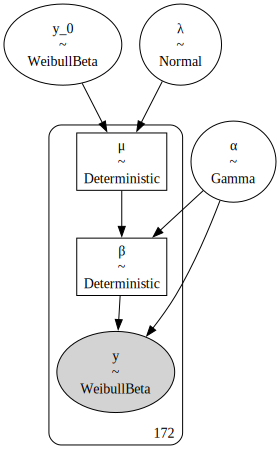

In [9]:
y_obs = mwm.Latency.values
x_obs = mwm.Day.values
gv = pm.model_to_graphviz(model_1(y_obs, x_obs, return_model=True))
gv

In [10]:
idata_1 = model_1(y_obs, x_obs, return_model=False)

arg: 1.5
arg: Add.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_0, λ, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


array([[<AxesSubplot: title={'center': 'λ'}>,
        <AxesSubplot: title={'center': 'λ'}>],
       [<AxesSubplot: title={'center': 'y_0'}>,
        <AxesSubplot: title={'center': 'y_0'}>],
       [<AxesSubplot: title={'center': 'α'}>,
        <AxesSubplot: title={'center': 'α'}>],
       [<AxesSubplot: title={'center': 'μ'}>,
        <AxesSubplot: title={'center': 'μ'}>],
       [<AxesSubplot: title={'center': 'β'}>,
        <AxesSubplot: title={'center': 'β'}>]], dtype=object)

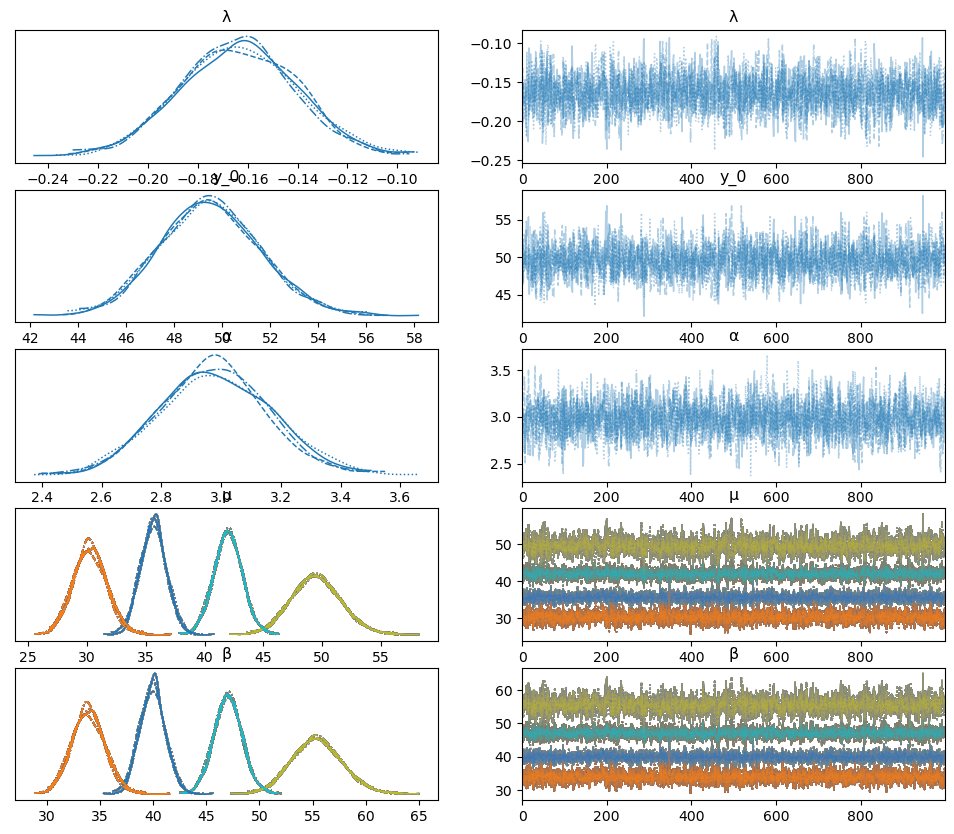

In [11]:
az.plot_trace(idata_1)

## Test trials

In [12]:
fpath = '../../resources/QPS/5xFAD-mouse/amiloride-behavioral-data-cleaned.xlsx'
mwm5 = pd.read_excel(fpath, sheet_name='rawdata MWM day 5', index_col=None)
mwm5['Condition'] = mwm5.Group.apply(lambda x: group2condition[x])
mwm5

,Cohort,Group,Sex,IRN,Target Zone Crossings,SE (%),NE (%),NW (%),SW (%),Condition
0,I,A,f,12913 A,2,18.90810,60.31960,5.19308,15.57920,WT
1,I,A,f,12915 A,2,25.56590,19.30760,28.09590,27.03060,WT
2,II,A,f,12937 A,2,20.90550,50.19970,10.78560,18.10920,WT
3,II,A,f,12955 A,1,20.10650,21.30490,33.28890,25.29960,WT
4,II,A,f,12957 A,1,44.60720,16.24500,5.72570,33.42210,WT
5,II,A,f,12961 A,5,11.85090,62.31690,9.45406,16.37820,WT
6,II,A,f,12967 A,3,8.38881,37.01730,35.68580,18.90810,WT
7,II,A,f,12979 A,4,15.57920,47.13720,30.49270,6.79095,WT
8,I,A,m,14138,3,14.78030,44.20770,26.23170,14.78030,WT
9,I,A,m,14142,6,8.65513,66.57790,20.63910,4.12783,WT


['named-figure/target-quadrant-barplot.png',
 'named-figure/target-quadrant-barplot.pdf']

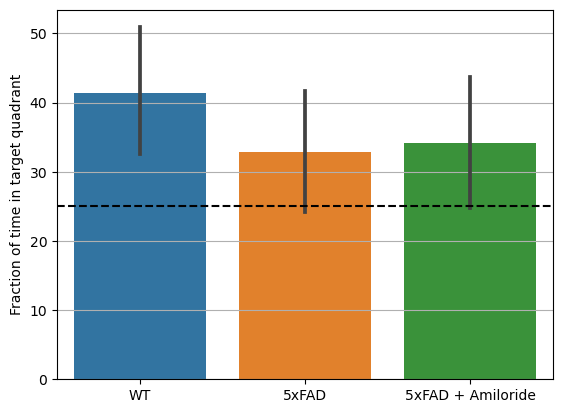

In [13]:
fig, ax = plt.subplots()
sns.barplot(x='Condition', y='NE (%)', data=mwm5, ax=ax)
ax.axhline(25, linestyle='dashed', color='k')
ax.set_xlabel('')
ax.set_ylabel('Fraction of time in target quadrant')
ax.grid(axis='y')
attila_utils.savefig(fig, 'target-quadrant-barplot')

In [14]:
def extract_data4dirichlet(group, mwm5=mwm5):
    a = mwm5.loc[mwm5.Group == group, 'SE (%)':'SW (%)'].to_numpy()[:, [1, 2, 3, 0]]
    return(a)

In [15]:
def my_dirichlet_plot(group, do_test_uniform=True, mwm5=mwm5, group2condition=group2condition):
    a = extract_data4dirichlet(group, mwm5=mwm5)
    dirichlet.plot(a, label=group2condition[group], do_test_uniform=do_test_uniform, do_MWM_correction=True, verbose=True, save_figure='named-figure/dirichlet-plot-group-' + group + '.png')


Result of the Dirichlet uniformity test for group WT:
# likelihood-ratio statistic (with MWM correction) = 14.3535
# p-value = 0.00246142
# MLE params under null hypothesis (uniformity)           :[2.02991233 2.02991233 2.02991233 2.02991233]
# MLE params under alternative hypothesis                 :[4.53177868 2.37172061 2.34260994 2.26527786]


/Users/jonesa7/tools/dirichlet.py:146: RuntimeWarning: divide by zero encountered in log
  logp = log(D).mean(axis=0)
/Users/jonesa7/tools/dirichlet.py:404: RuntimeWarning: invalid value encountered in scalar divide
  s1 = s0 * exp(-g/(s0*h + g)) # Newton on log s



Result of the Dirichlet uniformity test for group 5xFAD + Amiloride:
# likelihood-ratio statistic (with MWM correction) = 3.68336
# p-value = 0.297748
# MLE params under null hypothesis (uniformity)           :[1.787041 1.787041 1.787041 1.787041]
# MLE params under alternative hypothesis                 :[2.61028068 1.93986022 1.89460516 1.56812866]


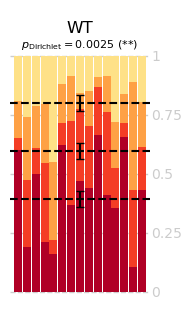

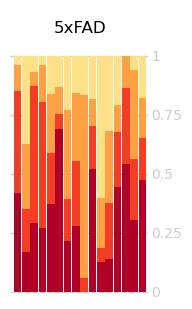

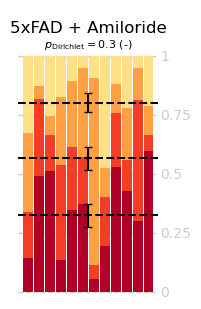

In [16]:
for group in mwm5.Group.unique():
    try:
        my_dirichlet_plot(group, do_test_uniform=True)
    except:
        my_dirichlet_plot(group, do_test_uniform=False)

In [17]:
%connect_info

{
  "shell_port": 50762,
  "iopub_port": 50763,
  "stdin_port": 50764,
  "control_port": 50766,
  "hb_port": 50765,
  "ip": "127.0.0.1",
  "key": "a6c6a093-0631d71400d5410e7e64aa7e",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f0e2a075-9ec8-4834-b2e0-71bac2d4e0b4.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
